In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import bokeh
import json
import us
import matplotlib.pyplot as plt
import seaborn as sns
#import warnings

from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import ColumnDataSource, figure, show, output_file
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter, Slider, HoverTool, Select, Div
from bokeh.palettes import brewer

from bokeh.io.doc import curdoc
from bokeh.layouts import WidgetBox, row, column, gridplot

from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler

from ipywidgets import interact, interact_manual, Dropdown, IntSlider

#warnings.filterwarnings('ignore')
output_notebook()

Loading BokehJS ...

In [2]:
# set path
#path = r'C:/Users/ShrekTheOger/Documents/GitHub/final-project-final-project-bowen-and-natasia'
path = r'C:\Users\engel\Documents\GitHub\final-project-final-project-bowen-and-natasia'

# Retrive Shape File

In [3]:
# https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html
county_shp = os.path.join(path+'/raw_data', 'cb_2020_us_county_20m', 'cb_2020_us_county_20m.shp')
county = gpd.read_file(county_shp)

In [4]:
#retrive shape file of universities
universities_shp = os.path.join(path+'/raw_data', 'Colleges_and_Universities-shp', 'Colleges_and_Universities.shp')
universities = gpd.read_file(universities_shp)

## Read & Manipulate Data for Plotting
Read the data that we already cleaned. The data cleaning process and regression analysis could be found in separate py file. 

In [5]:
# read data

# data for income and population
df = os.path.join(path+'/refined_data', 'df_income_pop.csv')
df = pd.read_csv(df)

# data for the universities 
uni_df = os.path.join(path+'/refined_data', 'uni_fund_df.csv')
uni_df = pd.read_csv(uni_df)

In [6]:
# notes to bowen, I found more succinct solution to create GEOID
df['GEOID'] = df['COUNTYFIPS'].apply(lambda x: '{0:05}'.format(x))

In [7]:
#df.insert(3, 'GEOID', l)
df.drop(labels=['state_id', 'county_id'], axis=1, inplace = True)

In [8]:
# Combine yearly data of county level income and population data with county geometries
df_shape = county.merge(df, how = 'inner', on='GEOID').set_geometry('geometry')

In [9]:
# merge university fund data with shape file university geometries
universities['IPEDSID'] = universities['IPEDSID'].astype(str).astype(int)
uni_shape = universities.merge(uni_df, how = 'inner', on = 'IPEDSID').set_geometry('geometry')
uni_shape = uni_shape.to_crs(df_shape.crs)

In [10]:
# filter unniversities that are the top universities
uni_filter = universities.loc[universities['IPEDSID'].isin(uni_df['IPEDSID'])].copy()
uni_filter = uni_filter[['IPEDSID', 'NAME', 'COUNTYFIPS']]

In [11]:
# combined all data: university fund, population, and income
# matched university fund data with the population and income data in that county
all_data = uni_df.merge(uni_filter, how = 'inner', on = ['IPEDSID'])
all_data['year'] = all_data['year'].astype(float)
all_data['COUNTYFIPS'] = all_data['COUNTYFIPS'].astype(float)

all_data = all_data.merge(df_shape, how = 'inner', on=['year', 'state', 'COUNTYFIPS'])

In [12]:
# create data to know how big is the fund for each county
# group fund by country FIPS
# this is to find out how big is the fund for each county
fund_county = all_data.groupby(['year','COUNTYFIPS','state', 'county','total_population', 
                                'total_native', 'total_born_in_state','total_born_out_state',
                                'total_born_outside_US','total_foreign_born','income_past12m'])['fund'].sum().reset_index()

fund_county['year'] = fund_county['year'].astype(int) 

# create column for share of foreigner 
fund_county['share_foreigner'] = (fund_county['total_foreign_born']/fund_county['total_population'])

# Bokeh Interactive Line Plot
We are making this interactive line plot, to show how the trend of population, income, and fund. User could select the state and county where the top 50 universities resides. 


In [20]:
uni_state = fund_county['state'].unique()

# create dictionary for ipwidget 
options = {state: all_data.loc[all_data['state'] == state, 'county'].unique().tolist() for state in uni_state}

In [21]:
#variables = ['Total Born in State', 'Total Born out State', 'Total Born outside US', 
#             'Total Foreigner', 'Income in Past 12 Month']

variables = ['Born in State', 'Born out State', 'Born outside US', 'Foreigner']
# create widget
first_widget = Dropdown(options=options.keys())
second_widget = Dropdown()
third_widget= Dropdown(options=variables)

In [22]:
# This dictionary contains the formatting for the data in the plots
format_data_line = [('total_born_in_state', 0, 1,'0,0', 'Born in State'),
                    ('total_born_out_state', 0, 1,'0,0', 'Born out State'),
                    ('total_born_outside_US', 0, 1,'0,0', 'Born outside US'),
                    ('total_foreign_born', 0, 1,'0,0', 'Foreigner'),
                    ('income_past12m', 0, 100000,'$0,0', 'Income 12 Months')]
 
#Create a DataFrame object from the dictionary 
format_df_line = pd.DataFrame(format_data_line, columns = ['field' , 'min_range', 'max_range' , 'format', 'verbage'])

In [23]:
def data_plot_pop(state, county, variable):
    df_filter = fund_county[(fund_county['state']==state) & (fund_county['county']==county)]
    
    data_plot = pd.DataFrame()
    data_plot['year'] = df_filter['year']
    data_plot[variable] = (df_filter[variable]/df_filter['total_population'])
    data_plot = data_plot.sort_values('year', ascending = True).reset_index(drop=True)
    
    return data_plot 

In [24]:
def data_plot_income(state, county):
    df_filter = fund_county[(fund_county['state']==state) & (fund_county['county']==county)]
    
    data_plot = pd.DataFrame()
    data_plot['year'] = df_filter['year']
    data_plot['income_past12m'] = df_filter['income_past12m']
    data_plot['fund'] = df_filter['fund']
    data_plot = data_plot.sort_values('year', ascending = True).reset_index(drop=True)
    
    return data_plot 

In [25]:
def plot_line_pop(variable, source): 
    var_title = format_df_line.loc[format_df_line['field'] == variable, 'verbage'].iloc[0]
    tool = [('value', '@'+variable+'{0.0000}'), ('year','@year')]
    plot = figure(title=f'Share of Total Population: {var_title}', x_axis_label='Year', y_axis_label='natural units', 
                  tooltips=tool, plot_height=400)
    
    r = plot.line(x='year', y=variable , source=source, color='blue')
    r = plot.circle(x='year', y=variable , source=source, color='grey')
    
    return plot

In [26]:
def plot_line_income(source): 
    tool = [('value', '@income_past12m'), ('year','@year')]
    plot = figure(title="Income in Past 12 Months", x_axis_label='Year', y_axis_label='in USD', 
                  tooltips=tool, plot_height=400)
    
    r = plot.line(x='year', y='income_past12m', source=source, color='green')
    r = plot.circle(x='year', y='income_past12m', source=source, color='grey')
    
    plot.yaxis.formatter = NumeralTickFormatter(format="$0")
    
    return plot

In [27]:
def plot_line_fund(source): 
    tool = [('value', '@fund'), ('year','@year')]
    plot = figure(title="R&D Fund", x_axis_label='Year', y_axis_label='in USD', 
                  tooltips=tool, plot_height=400)
    
    r = plot.line(x='year', y='fund', source=source, color='magenta')
    r = plot.circle(x='year', y='fund', source=source, color='grey')
    
    plot.yaxis.formatter = NumeralTickFormatter(format="$0")
    
    return plot

In [28]:
# https://docs.bokeh.org/en/latest/docs/user_guide/data.html
def update(*args):
    second_widget.options = options[first_widget.value]

first_widget.observe(update)

initial_data = data_plot_pop('Michigan', 'Washtenaw County', 'total_born_outside_US')
source_pop = ColumnDataSource(data=initial_data)

plot = plot_line_pop('total_born_outside_US', source_pop)

def update_plot(state, county, variable):
    var = format_df_line.loc[format_df_line['verbage'] == variable, 'field'].iloc[0]
    update_data = data_plot_pop(state, county, var)
    source_pop = ColumnDataSource(data=update_data)
    plot_pop_line = plot_line_pop(var, source_pop)
    
    show(plot_pop_line)
interact(update_plot, state=first_widget, county=second_widget, variable=third_widget);

interactive(children=(Dropdown(description='state', options=('Alabama', 'Arizona', 'California', 'Colorado', '…

In [29]:
# https://docs.bokeh.org/en/latest/docs/user_guide/data.html
# https://docs.bokeh.org/en/latest/docs/first_steps/first_steps_4.html

def update(*args):
    second_widget.options = options[first_widget.value]

first_widget.observe(update)
initial_data = data_plot_income('Michigan', 'Washtenaw County')

source_income = ColumnDataSource(data=initial_data)

# plot income 
plot_income = plot_line_income(source_income)

# plot fund
plot_fund = plot_line_fund(source_income)

def update_plot_income(state, county):
    update_data = data_plot_income(state, county)
    source_income.data = update_data
    
    show(column(plot_income, plot_fund))
interact(update_plot_income, state=first_widget, county=second_widget);

interactive(children=(Dropdown(description='state', options=('Alabama', 'Arizona', 'California', 'Colorado', '…

## Create Static Line Plot: distribution of the dataset
Using this static plot, we would like to see the distribution of the data among the to 50 universities based on the county it resides. We would like to see if there are any outliers especially regarding the R&D fund disbursement along with the income level. We also wanted to see of the share of foreign population increases more significantly in certain state.

In [30]:
# function to generate color
def color_gen(n):
    palette = bokeh.palettes.cividis(n)
    for color in palette:
        yield color

In [31]:
# create plot with multiple lines
def plot_multiline(df, xaxis, yaxis, hue, title):
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 10)
    sns.set_theme(style='whitegrid')
    
    graph = sns.lineplot(data=df, x=xaxis, y=yaxis, hue=hue, style=hue, markers=True);
    graph.legend(loc='center left', bbox_to_anchor=(1.00, 0.5), ncol=1);
    graph.set(title=title, ylabel='natural units');
    
    return graph

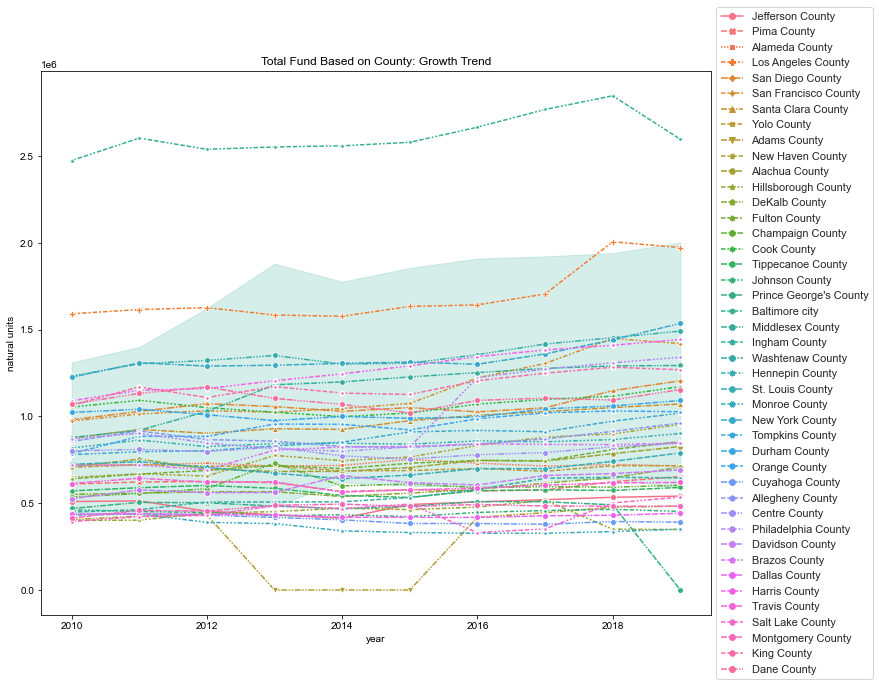

In [32]:
# https://stackoverflow.com/questions/44642082/text-or-legend-cut-from-matplotlib-figure-on-savefig
fund_trend = plot_multiline(fund_county, 'year', 'fund', 'county', 'Total Fund Based on County: Growth Trend')
fund_trend;
fund_trend.figure.savefig(path+'/static png/fund_trend.png', bbox_inches="tight")

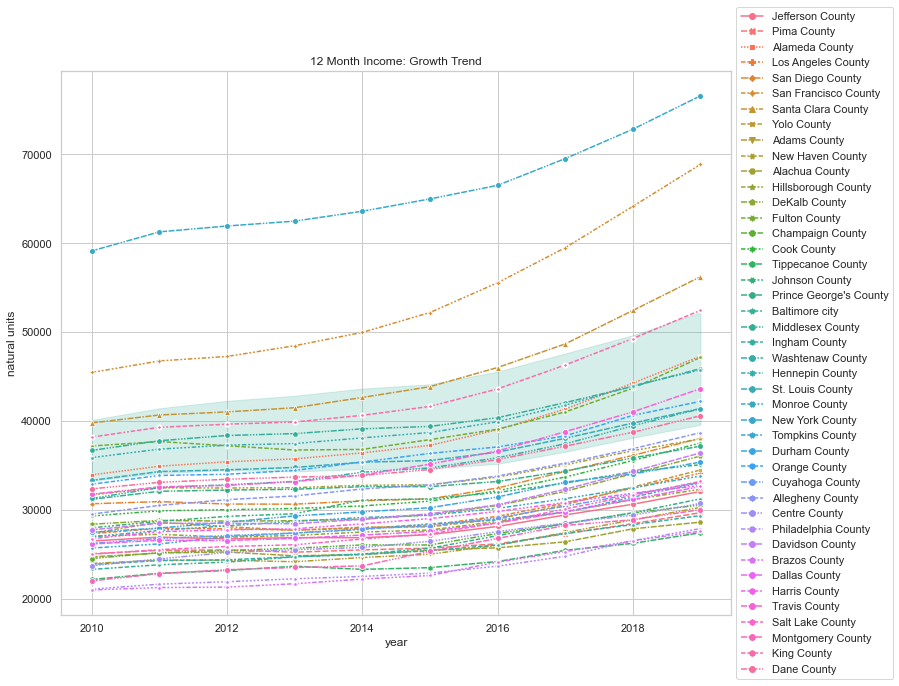

In [33]:
income_trend = plot_multiline(fund_county, 'year', 'income_past12m', 'county', '12 Month Income: Growth Trend')
income_trend;
income_trend.figure.savefig(path+'/static png/income_trend.png', bbox_inches="tight")

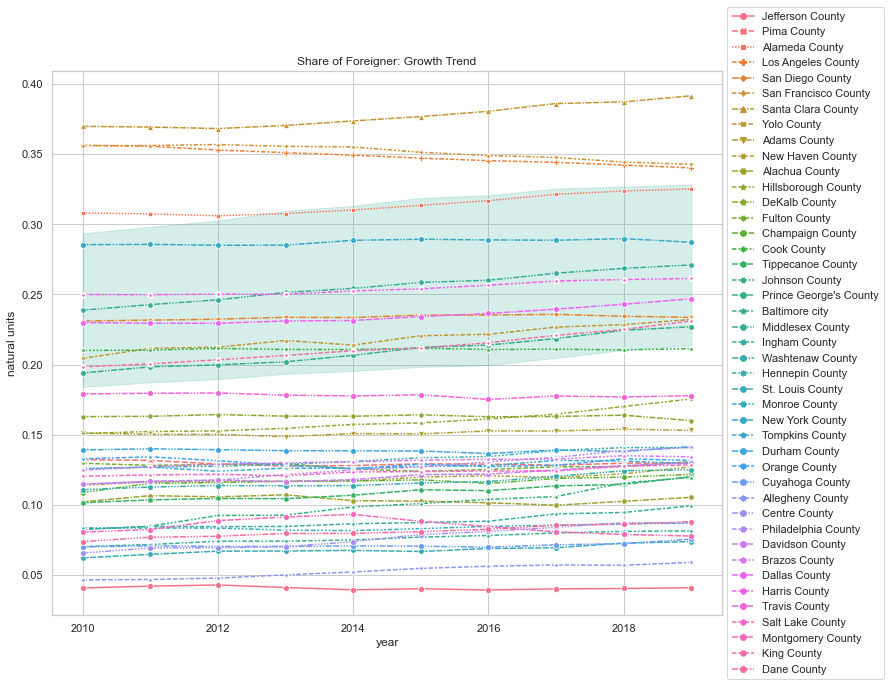

In [34]:
foreigner_share_trend = plot_multiline(fund_county, 'year', 'share_foreigner', 'county', 'Share of Foreigner: Growth Trend')
foreigner_share_trend;
foreigner_share_trend.figure.savefig(path+'/static png/foreigner_share_trend.png', bbox_inches="tight")